In [3]:

import gym
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from stable_baselines3 import DQN, PPO, A2C
import pygame
import threading
import time
import gym
from gym import spaces
import numpy as np
import pygame
import gym
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from stable_baselines3 import DQN, PPO, A2C
import random
import matplotlib.pyplot as plt

class PongEnvironment(gym.Env):
    def __init__(self):
        super(PongEnvironment, self).__init__()
        self.width = 400
        self.height = 300
        self.ball_radius = 10
        self.paddle_width = 10
        self.paddle_height = 60
        self.paddle_offset = 20
        self.ball_pos = np.array([self.width // 2, self.height // 2], dtype=float)
        self.ball_vel = np.array([5, 1], dtype=float) * 100
        self.paddle_pos = self.height // 2
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Pong")

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(5,), dtype=np.float32)

    def reset(self):
        self.time_step=0
        self.start_time=time.time()
        self.tot_reward=0
        self.ball_pos = np.array([self.width // 2, self.height // random.randrange(1,10)], dtype=float)
        self.ball_vel = np.array([random.random(), random.random()], dtype=float) * 100
        self.paddle_pos = self.height // 2
        return self.get_state()

    def step(self, action):

        self.time_step+=1
        if action == 0:
            move = -5
        else:
            move = 5
        self.move_paddle(move)
        self.ball_pos += self.ball_vel

        if (
            self.ball_pos[1] <= self.ball_radius
            or self.ball_pos[1] >= self.height - self.ball_radius
        ):
            self.ball_vel[1] *= -1

        reward = 0
        done = False

        if self.ball_pos[0] <= self.paddle_width + self.ball_radius:
            if (
                self.paddle_pos - self.paddle_height / 2
                <= self.ball_pos[1]
                <= self.paddle_pos + self.paddle_height / 2
            ):
                self.ball_vel[0] *= -1
                reward = 1
                self.tot_reward+=1
            else:
                reward = 0
                done = True
        if self.tot_reward>10 or time.time()-self.start_time>30:
                print('xxx')
                done = True
        if self.ball_pos[0] >= self.width - self.ball_radius - self.paddle_width:
            self.ball_vel[0] *= -1

        return self.get_state(), reward, done, {}

    def move_paddle(self, move):
        self.paddle_pos = np.clip(
            self.paddle_pos + move,
            self.paddle_height / 2,
            self.height - self.paddle_height / 2,
        )

    def get_state(self):
        return np.array(
            [
                self.ball_pos[0] / self.width,
                self.ball_pos[1] / self.height,
                self.ball_vel[0] / 100,
                self.ball_vel[1] / 100,
                self.paddle_pos / self.height,
            ]
        )

    def render(self, mode="rgb_array"):
        self.screen.fill((0, 0, 0))
        pygame.draw.rect(
            self.screen,
            (255, 255, 255),
            pygame.Rect(
                0,
                int(self.paddle_pos - self.paddle_height / 2),
                self.paddle_width,
                self.paddle_height,
            ),
        )
        pygame.draw.circle(
            self.screen,
            (255, 255, 255),
            (int(self.ball_pos[0]), int(self.ball_pos[1])),
            self.ball_radius,
        )
        pygame.display.update()

        if mode == "rgb_array":
            data = pygame.surfarray.array3d(pygame.display.get_surface())
            return np.transpose(data, (1, 0, 2))
        return np.transpose(data, (1, 0, 2))



In [29]:
class DQNAgent:
    def __init__(self, env):
        self.model = DQN("MlpPolicy", env, verbose=1)
        self.env=env

    def train(self, total_timesteps):
        self.model.learn(total_timesteps=total_timesteps)
    def calculate_expertise(self, num_episodes=100):
        total_rewards = 0
        total_rewards_list=[]
        for zz in range(num_episodes):
            obs = self.env.reset()
            done = False
            episode_reward = 0

            while not done and episode_reward<100:
                action, _ = self.model.predict(obs)
                obs, reward, done, _ = self.env.step(action)
                episode_reward += reward
            total_rewards += episode_reward
            print(episode_reward)
            total_rewards_list.append(episode_reward)

        average_reward = total_rewards / num_episodes
        return average_reward,total_rewards_list


class PPOAgent:
    def __init__(self, env):
        self.model = PPO("MlpPolicy", env, verbose=1)
        self.env=env


    def train(self, total_timesteps):
        self.model.learn(total_timesteps=total_timesteps)
    def calculate_expertise(self, num_episodes=100):
        total_rewards = 0
        total_rewards_list=[]
        for zz in range(num_episodes):
            obs = self.env.reset()
            done = False
            episode_reward = 0

            while not done and total_rewards<100:
                action, _ = self.model.predict(obs)
                obs, reward, done, _ = self.env.step(action)
                episode_reward += reward

            total_rewards += episode_reward
            print(episode_reward)
            total_rewards_list.append(episode_reward)
            print(zz)

        average_reward = total_rewards / num_episodes
        return average_reward,total_rewards_list


class A2CAgent:
    def __init__(self, env):
        self.model = A2C("MlpPolicy", env, verbose=1)
        self.env=env

    def train(self, total_timesteps):
        self.model.learn(total_timesteps=total_timesteps)

    def calculate_expertise(self, num_episodes=100):
        total_rewards = 0
        total_rewards_list=[]
        for zz in range(num_episodes):
            obs = self.env.reset()
            done = False
            episode_reward = 0

            while not done and episode_reward<100:
                action, _ = self.model.predict(obs)
                obs, reward, done, _ = self.env.step(action)
                episode_reward += reward

            total_rewards += episode_reward
            total_rewards_list.append(episode_reward)

        average_reward = total_rewards / num_episodes
        return average_reward,total_rewards_list
all_rewards=[[],[],[]]
for _ in range(10):

  env = DummyVecEnv([lambda: PongEnvironment()])

  dqn_agent = DQNAgent(env)
  ppo_agent = PPOAgent(env)
  a2c_agent = A2CAgent(env)




  # dqn_agent.model = DQN.load('./dqn.zip')
  # ppo_agent.model = PPO.load('./ppo.zip')
  # a2c_agent.model = A2C.load('./a2c.zip')


  total_timesteps = 100000
  dqn_agent.train(total_timesteps)
  ppo_agent.train(total_timesteps)
  a2c_agent.train(total_timesteps)


  dqn_a_r,dqn_r_l = dqn_agent.calculate_expertise(100)
  ppo_a_r,ppo_r_l  = ppo_agent.calculate_expertise(100)
  a2c_a_r,a2c_r_l   = a2c_agent.calculate_expertise(100)
  all_rewards[0].append(dqn_r_l)
  all_rewards[1].append(ppo_r_l)
  all_rewards[2].append(a2c_r_l)



Using cpu device
Using cpu device
Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8871     |
|    time_elapsed     | 0        |
|    total_timesteps  | 102      |
----------------------------------
xxx
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 7119     |
|    time_elapsed     | 0        |
|    total_timesteps  | 294      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.969    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6536     |
|    time_elapsed     | 0        |
|    total_timesteps  | 330      |
----------------------------------


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
|    total_timesteps  | 86399    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 4.57e-05 |
|    n_updates        | 9099     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 924      |
|    fps              | 1861     |
|    time_elapsed     | 46       |
|    total_timesteps  | 86470    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00842  |
|    n_updates        | 9117     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 928      |
|    fps              | 1852     |
|    time_elapsed     | 46       |
|    total_timesteps  | 86887    |
| tr

In [34]:
import torch
import torch.nn.functional as F

import random
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pygame

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))  # Convert states to numpy arrays for storage

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # for b in batch:
        #     print(b)
        #     print(f'{(list(b[0]))}')
        #     print(f'-{(list(b[1]))}')
        #     print(f'-{(list(b[2]))}')
        #     print(f'-{(list(b[3]))}')
        #     print(f'-{(b[4])}-')
        #     print(len(b[1]))
        #     print(len(b[2]))
        #     print(len(b[3]))
        #     # print(len(b[4]))
        state, action, reward, next_state, done = map(np.stack, zip(*batch))

        return torch.FloatTensor(state), torch.LongTensor(action), torch.FloatTensor(reward), torch.FloatTensor(next_state), torch.FloatTensor(done)


class PongEnvironment:
    def __init__(self, width=400, height=300):
        self.width = width
        self.height = height
        self.ball_radius = 10
        self.paddle_width = 10
        self.paddle_height = 60
        self.paddle_offset = 20
        self.ball_pos = np.array(
            [self.width // 2, random.randint(0, self.height) // 2], dtype=float
        )
        self.ball_vel = np.array([0.03, 0.01], dtype=float) * 100
        self.paddle_pos = random.randint(0, self.height)
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption("Pong")

    def reset(self):
        self.start_time = time.time()
        self.total_reward = 0
        self.ball_pos = np.array(
            [self.width // 2, random.randint(0, self.height)], dtype=float
        )
        self.ball_vel = np.array([0.03, 0.01], dtype=float) * 100
        self.paddle_pos = random.randint(0, self.height)
        return torch.FloatTensor(self.get_state())

    def step(self, action):
        if action == 0:
            move = -5
        else:
            move = 5
        self.move_paddle(move)
        self.ball_pos += self.ball_vel

        if (
            self.ball_pos[1] <= self.ball_radius
            or self.ball_pos[1] >= self.height - self.ball_radius
        ):
            self.ball_vel[1] *= -1

        reward = 0
        done = False

        if self.ball_pos[0] <= self.paddle_width + self.ball_radius:
            if (
                self.paddle_pos - self.paddle_height / 2
                <= self.ball_pos[1]
                <= self.paddle_pos + self.paddle_height / 2
            ):
                self.ball_vel[0] *= -1
                reward = 1
                self.total_reward += 1
            else:
                reward = 0
                done = True
        if self.total_reward > 10 or time.time() - self.start_time > 10:
            done = True
        if self.ball_pos[0] >= self.width - self.ball_radius - self.paddle_width:
            self.ball_vel[0] *= -1

        return torch.FloatTensor(self.get_state()), reward, done

    def move_paddle(self, move):
        self.paddle_pos = np.clip(
            self.paddle_pos + move,
            self.paddle_height / 2,
            self.height - self.paddle_height / 2,
        )

    def get_state(self):
        return np.array(
            [
                self.ball_pos[0] / self.width,
                self.ball_pos[1] / self.height,
                self.ball_vel[0] / 100,
                self.ball_vel[1] / 100,
                self.paddle_pos / self.height,
            ]
        )

    def render(self):
        self.screen.fill((0, 0, 0))
        pygame.draw.rect(
            self.screen,
            (255, 255, 255),
            pygame.Rect(
                0,
                int(self.paddle_pos - self.paddle_height / 2),
                self.paddle_width,
                self.paddle_height,
            ),
        )
        pygame.draw.circle(
            self.screen,
            (255, 255, 255),
            (int(self.ball_pos[0]), int(self.ball_pos[1])),
            self.ball_radius,
        )
        pygame.display.flip()

class PPO(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(PPO, self).__init__()
        self.p = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=-1),
        )
        self.v = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state):
        action_probs = self.p(state)
        value = self.v(state)
        return action_probs, value



batch_size=256
def train_ppo(env, policy, optimizer, replay_buffer, clip_epsilon=0.2, epochs=10, batch_size=64):
    all_rewards=[]
    for episode in range(200):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            action_probs, _ = policy(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            next_state, reward, done = env.step(action.item())

            # Add the agent's experience to the replay buffer
            replay_buffer.add(state, action, reward, next_state, done)

            state = next_state if not done else env.reset()
            total_reward += reward

        if len(replay_buffer.buffer) > batch_size:
            # Sample a batch of experiences from the replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

            # Convert lists to tensors
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).view(-1, 1)
            rewards = torch.FloatTensor(rewards).view(-1, 1)
            dones = torch.FloatTensor(dones).view(-1, 1)
            next_states = torch.FloatTensor(next_states)

            # Compute advantages and returns
            _, values = policy(states)
            _, next_values = policy(next_states)
            returns = rewards + 0.99 * next_values * (1 - dones)
            advantages = returns - values.detach()

            # Compute policy loss
            action_probs, _ = policy(states)
            action_dist = torch.distributions.Categorical(action_probs)
            log_probs = action_dist.log_prob(actions.squeeze(-1)).view(-1, 1)
            old_action_probs = action_dist.probs.detach()
            ratios = torch.exp(log_probs - torch.log(old_action_probs))
            obj = ratios * advantages
            obj_clipped = ratios.clamp(1.0 - clip_epsilon, 1.0 + clip_epsilon) * advantages
            actor_loss = -torch.min(obj, obj_clipped).mean()

            # Compute value function loss
            critic_loss = F.smooth_l1_loss(values, returns.detach())

            # Total loss
            loss = actor_loss + 0.5 * critic_loss

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        all_rewards.append(total_reward)

        print(f"Episode {episode}, Total Reward: {total_reward}")
    return all_rewards

import torch

rs=[]
for _ in range(10):
    env = PongEnvironment()
    env2 = PongEnvironment()
    replay_buffer = ReplayBuffer(capacity=100_000)

    # Define state and action sizes
    state_size = env.get_state().shape[0]
    action_size = 2  # up and down

    # Define hidden size
    hidden_size = 64

    # Initialize policy (ActorCritic network)
    policy = PPO(state_size, action_size, hidden_size)

    # Define optimizer
    optimizer = torch.optim.Adam(policy.parameters(), lr=0.001)

    # Train policy with PPO
    alls_ppo=train_ppo(env, policy, optimizer,replay_buffer)
    rs.append(alls_ppo)



Episode 0, Total Reward: 0
Episode 1, Total Reward: 0
Episode 2, Total Reward: 0
Episode 3, Total Reward: 0
Episode 4, Total Reward: 0
Episode 5, Total Reward: 0
Episode 6, Total Reward: 0
Episode 7, Total Reward: 0
Episode 8, Total Reward: 0
Episode 9, Total Reward: 0
Episode 10, Total Reward: 0
Episode 11, Total Reward: 0
Episode 12, Total Reward: 0
Episode 13, Total Reward: 0
Episode 14, Total Reward: 0
Episode 15, Total Reward: 0
Episode 16, Total Reward: 0
Episode 17, Total Reward: 1
Episode 18, Total Reward: 0
Episode 19, Total Reward: 0
Episode 20, Total Reward: 0
Episode 21, Total Reward: 0
Episode 22, Total Reward: 0
Episode 23, Total Reward: 0
Episode 24, Total Reward: 0
Episode 25, Total Reward: 0
Episode 26, Total Reward: 0
Episode 27, Total Reward: 0
Episode 28, Total Reward: 0
Episode 29, Total Reward: 0
Episode 30, Total Reward: 2
Episode 31, Total Reward: 0
Episode 32, Total Reward: 0
Episode 33, Total Reward: 0
Episode 34, Total Reward: 1
Episode 35, Total Reward: 1
Ep

200
[ 0.01596902 -0.00556653  0.0719719   0.06491632  0.06305516  0.06295564
  0.09374747  0.12549453  0.13377292  0.13193306  0.1259484   0.11830213
  0.12415929  0.15660835  0.15077873  0.15048053  0.14273663  0.16254927
  0.17036356  0.17727667  0.17423693  0.1841505   0.17617299  0.18102989
  0.18541691  0.18938702  0.20280012  0.19561796  0.19083525  0.18689054
  0.19772382  0.19756344  0.19820001  0.20051216  0.20423073  0.20823292
  0.20533363  0.20148708  0.21572889  0.21006757  0.20971725  0.21635515
  0.21132363  0.21363105  0.20888369  0.21493296  0.21214716  0.21573128
  0.22315357  0.22655504  0.23085205  0.23322445  0.23462206  0.23253705
  0.23134319  0.23352832  0.23031002  0.23074306  0.23723412  0.2376
  0.24330275  0.24166834  0.23970114  0.24496502  0.24767735  0.24331517
  0.24551173  0.24452777  0.24911519  0.24640653  0.24727107  0.24685008
  0.25003362  0.25179259  0.25655522  0.26145842  0.26063117  0.26006527
  0.26174137  0.26074569  0.26315985  0.26531247  0

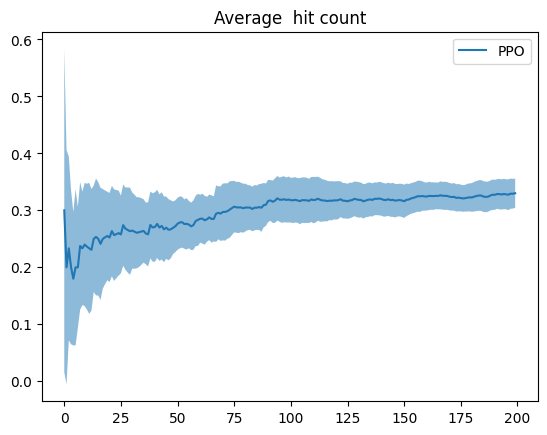

[ 0.01596902 -0.08594193  0.01596902 -0.08594193 -0.08594193  0.01596902
 -0.04792257  0.08422121 -0.04792257  0.01596902 -0.04792257 -0.04792257
 -0.04792257  0.19009679  0.01596902 -0.04792257 -0.08594193  0.09635811
  0.01596902  0.01596902 -0.04792257  0.08422121 -0.08594193  0.01596902
 -0.09686975 -0.04792257  0.41596902 -0.08594193 -0.04792257 -0.04792257
 -0.09686975 -0.04792257 -0.04792257  0.01596902  0.01596902  0.01596902
 -0.08594193 -0.04792257  0.56622403 -0.08594193  0.01596902  0.19009679
  0.          0.09635811  0.          0.09635811 -0.08594193  0.01596902
  0.09635811  0.09635811  0.08422121  0.09635811  0.01596902 -0.08594193
  0.01596902 -0.04792257 -0.08594193  0.09635811  0.41596902  0.09635811
  0.09635811  0.01596902 -0.08594193  0.09635811  0.19009679 -0.08594193
  0.01596902  0.00395625  0.09635811 -0.04792257  0.19009679  0.01596902
  0.09635811  0.19009679  0.08422121  0.19009679 -0.04792257  0.01596902
  0.01596902 -0.04792257  0.09635811  0.01596902  0

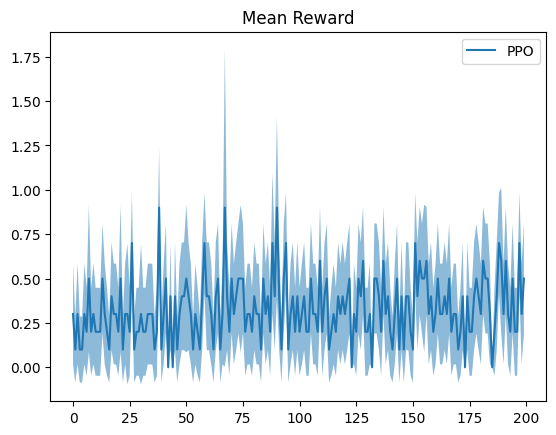

In [49]:
alls_3=[]
for alls_1 in rs:
    t=0
    list_1=[]
    for i in range(200):
        t+=alls_1[i]
        list_1.append(t/(i+1))
    alls_3.append(list_1)
    rewards=alls_3
mean_regret = np.mean(rewards, axis=0)
std_regret = np.std(rewards, axis=0)

upper_bound = (mean_regret + 1.96 * std_regret / np.sqrt(len(rewards))).flatten()
lower_bound = (mean_regret - 1.96 * std_regret / np.sqrt(len(rewards))).flatten()

fig, ax = plt.subplots()
ax.plot(mean_regret, label="PPO")
ax.fill_between(np.arange(len(mean_regret)).flatten(), lower_bound ,upper_bound , alpha=0.5)
ax.set_title("Average  hit count")
# ax.plot(np.mean(rs, axis=0))

plt.legend()

plt.show()

mean_regret = np.mean(rs, axis=0)
std_regret = np.std(rs, axis=0)

upper_bound = (mean_regret + 1.96 * std_regret / np.sqrt(len(rewards))).flatten()
lower_bound = (mean_regret - 1.96 * std_regret / np.sqrt(len(rewards))).flatten()

fig, ax = plt.subplots()
ax.plot(mean_regret, label="PPO")
ax.fill_between(np.arange(len(mean_regret)).flatten(), lower_bound ,upper_bound , alpha=0.5)
ax.set_title("Mean Reward")
# ax.plot(np.mean(rs, axis=0))

plt.legend()

plt.show()

# plt.legend()
# # Show the plot
# plt.show()
